In [1]:
import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from shapely.geometry import Polygon

import bento as bt

mpl.style.use("dark_background")


In [2]:
adata = bt.ds.load_dataset("seqfish")


In [3]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


In [4]:
bt.tl.analyze_shapes(adata, shape_names=["cell"], feature_names="area")


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'n_genes_by_counts')

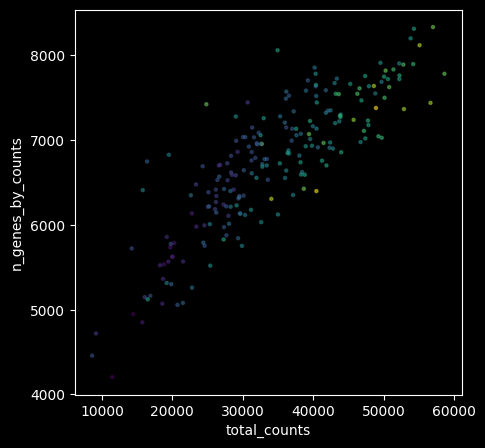

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(
    x=adata.obs["total_counts"],
    y=adata.obs["n_genes_by_counts"],
    c=adata.obs["cell_area"],
    s=5,
    alpha=0.5,
    cmap="viridis",
)
plt.xlabel("total_counts")
plt.ylabel("n_genes_by_counts")


In [6]:
adata.layers["log"] = sc.pp.log1p(adata.X)


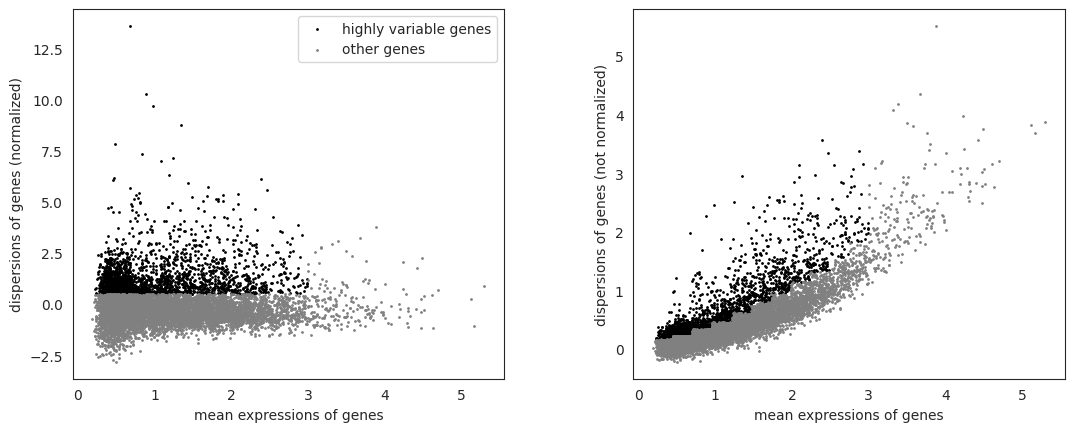

In [7]:
sc.pp.highly_variable_genes(adata, layer="log")
with sns.axes_style("white"):
    sc.pl.highly_variable_genes(adata)


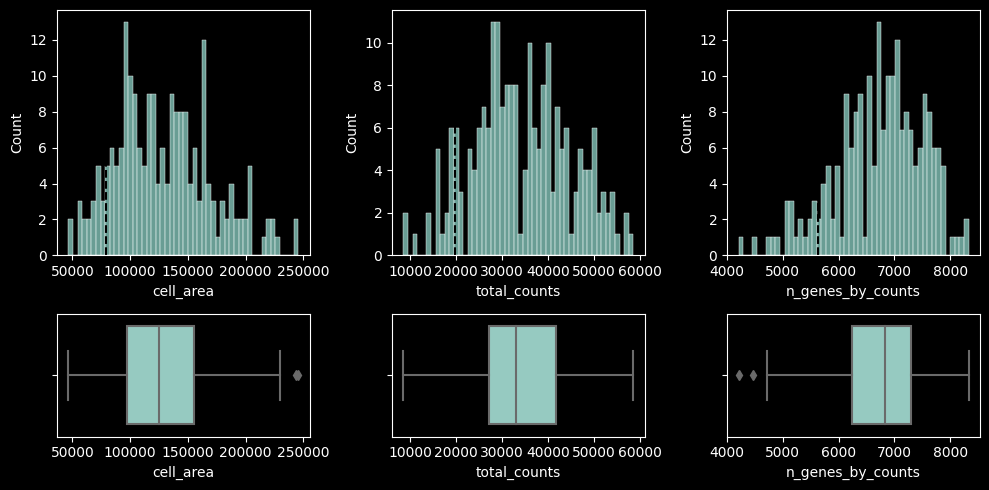

In [8]:
# Plot histogram of cell area, total counts, and n_genes_by_counts in subplots. Draw boxplots underneath each histogram.
fig, axes = plt.subplots(2, 3, figsize=(10, 5), gridspec_kw={"height_ratios": [2, 1]})

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[0])
):
    sns.histplot(adata.obs[feature], ax=ax, bins=50)
    ax.axvline(np.quantile(adata.obs[feature], 0.10), c="k", ls="--")

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[1])
):
    sns.boxplot(x=adata.obs[feature], ax=ax, orient="h")
    ax.set_xlabel(feature)

plt.tight_layout()


In [9]:
min_area = np.quantile(adata.obs["cell_area"], 0.10)
min_cell_counts = np.quantile(adata.obs["total_counts"], 0.10)
min_gene_counts = np.quantile(adata.obs["n_genes_by_counts"], 0.10)

adata = adata[adata.obs["cell_area"] > min_area]
adata = adata[adata.obs["total_counts"] > min_cell_counts]
adata = adata[adata.obs["n_genes_by_counts"] > min_gene_counts]
adata


View of AnnData object with n_obs × n_vars = 174 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'total_counts', 'cell_area'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'points', 'hvg'
    layers: 'spliced', 'unspliced', 'log'

In [10]:
adata = adata[adata.obs["nucleus_shape"].apply(lambda s: isinstance(s, Polygon))]
bt.sync(adata)


In [11]:
importlib.reload(bt.tl._neighborhoods)
importlib.reload(bt.tl._flux)
importlib.reload(bt.tl)
importlib.reload(bt)

r = 50
dx = 0.1
res = 0.1
bt.settings.log.setLevel("WARNING")

bt.tl.flux(adata, radius=r, train_size=1, use_highly_variable=True, res=res)


  0%|          | 0/156 [00:00<?, ?it/s]

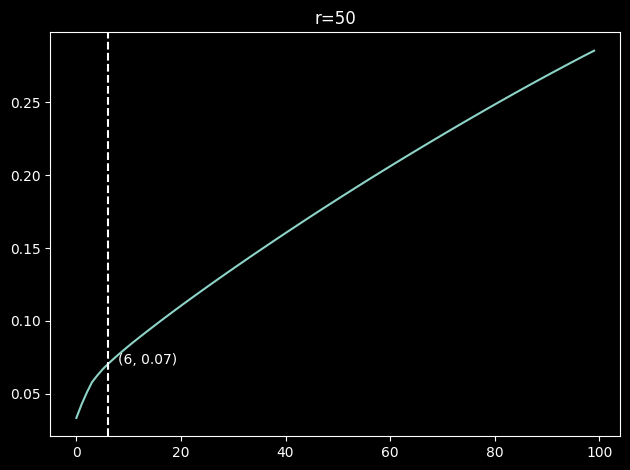

In [12]:
ax = sns.lineplot(np.cumsum(adata.uns["flux_variance_ratio"]))
elbow = adata.uns["flux_n_components"]
cumvar = np.sum(adata.uns["flux_variance_ratio"][: elbow + 1])
ax.axvline(elbow, ls="--")
ax.text(elbow + 2, cumvar, f"({elbow}, {cumvar:.2f})")
ax.set_title(f"r={r}")

plt.tight_layout()


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

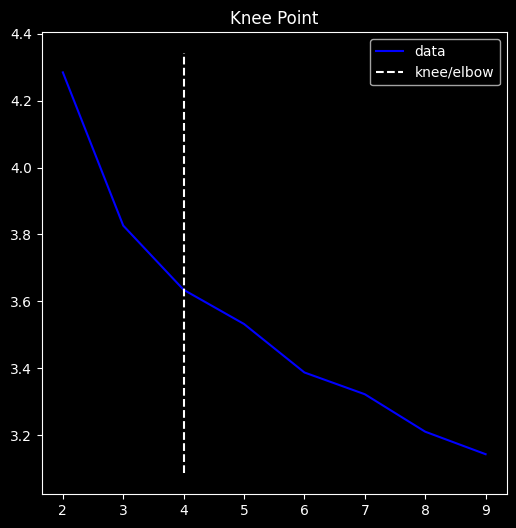

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

In [13]:
bt.tl.fluxmap(adata, n_clusters=range(2, 10), res=res, train_size=0.5)


Text(0.5, 1.0, 'radius=50.00')

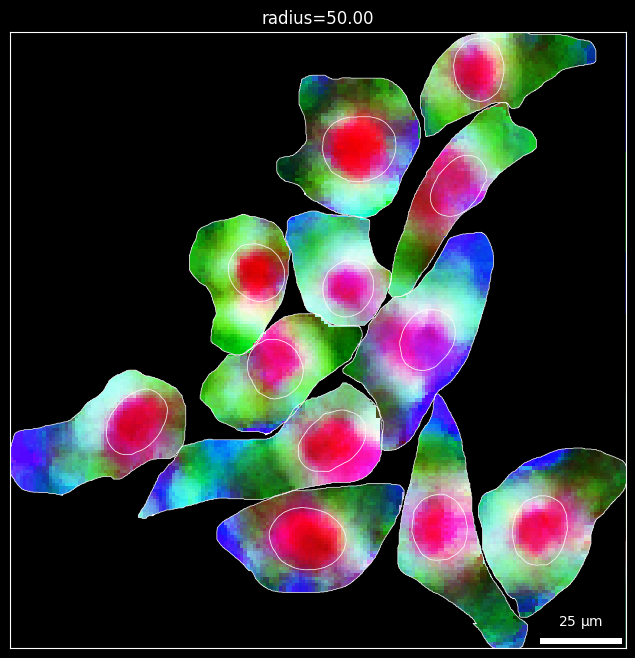

In [14]:
importlib.reload(bt)
importlib.reload(bt.pl)

mpl.style.use("dark_background")
plt.figure(figsize=(8, 8))
bt.pl.flux(adata, res=res, alpha=False, dx=dx)
plt.title(f"radius={r:.2f}")


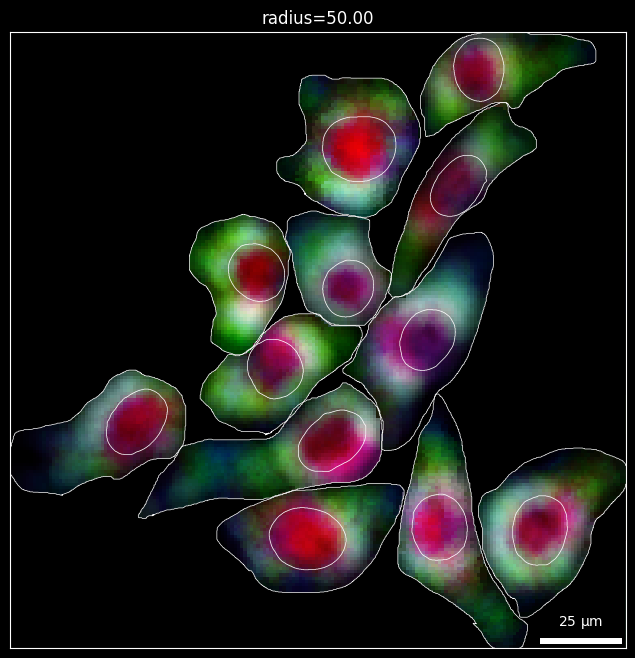

In [15]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

mpl.style.use("dark_background")
plt.figure(figsize=(8, 8))

bt.pl.flux(adata, res=res, alpha=True, dx=dx, title=f"radius={r:.2f}")


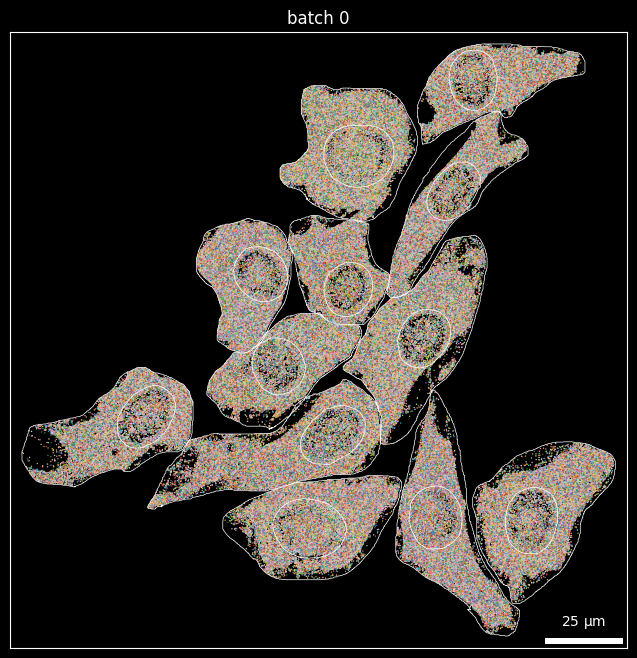

In [16]:
plt.figure(figsize=(8, 8))
bt.pl.points(adata, dx=dx, s=1, hue="gene", legend=False, palette="tab20")


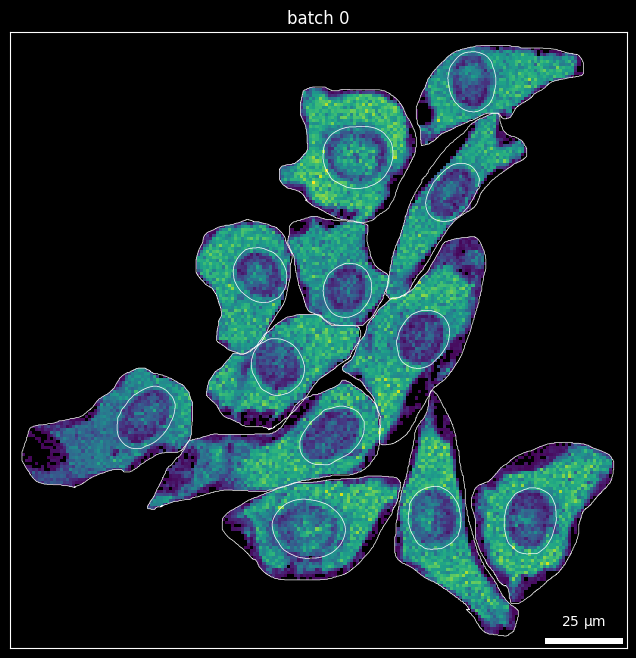

In [17]:
plt.figure(figsize=(8, 8))
bt.pl.density(adata, dx=dx, cmap="viridis", binwidth=10)


<Axes: >

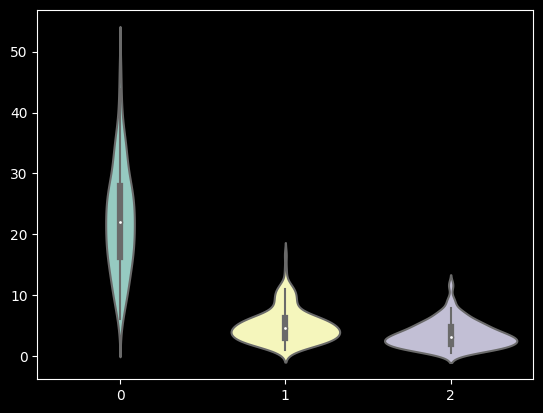

In [18]:
cell_flux = pd.DataFrame(adata.uns["flux_embed"][:, :3]).groupby(
    adata.uns["cell_raster"]["cell"].values
)
intra_var = cell_flux.var()
inter_var = cell_flux.mean().var()

sns.violinplot(
    data=intra_var / inter_var,
)


In [19]:
sns.color_palette(
    [
        "#FFD166",
        "#06D6A0",
        "#118ab2",
        "#396270",
        "#f78c6b",
        "#ef476f",
    ]
)


[(1.0, 0.8196078431372549, 0.4),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.2235294117647059, 0.3843137254901961, 0.4392156862745098),
 (0.9686274509803922, 0.5490196078431373, 0.4196078431372549),
 (0.9372549019607843, 0.2784313725490196, 0.43529411764705883)]

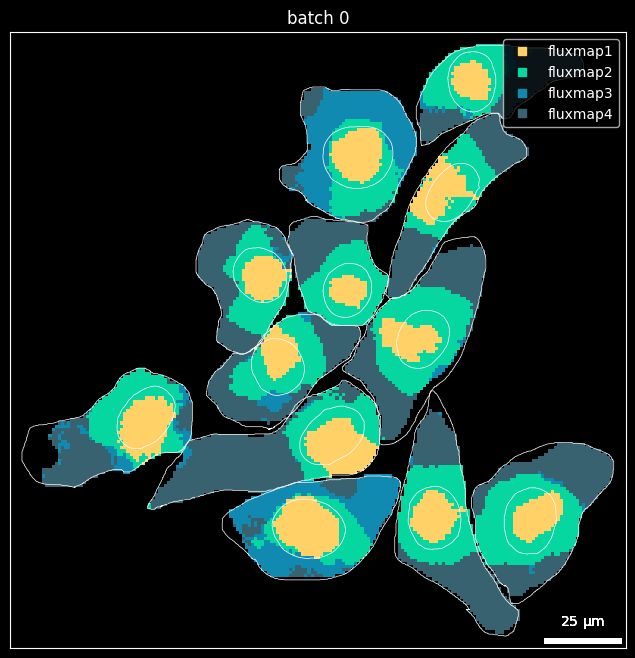

In [20]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

fig = plt.figure(figsize=(8, 8))
bt.pl.fluxmap(
    adata,
    dx=dx,
    palette=bt.colors.bento6,
    linewidth=0,
)
plt.legend()


In [21]:
adata.uns["flux_genes"] = [g.upper() for g in adata.uns["flux_genes"]]


In [22]:
bt.tl.fe_fazal2019(adata)


1353 samples of mat are empty, they will be removed.
Running wsum on mat with 214146 samples and 1700 targets for 8 sources.
Infering activities on 22 batches.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.62s/it]


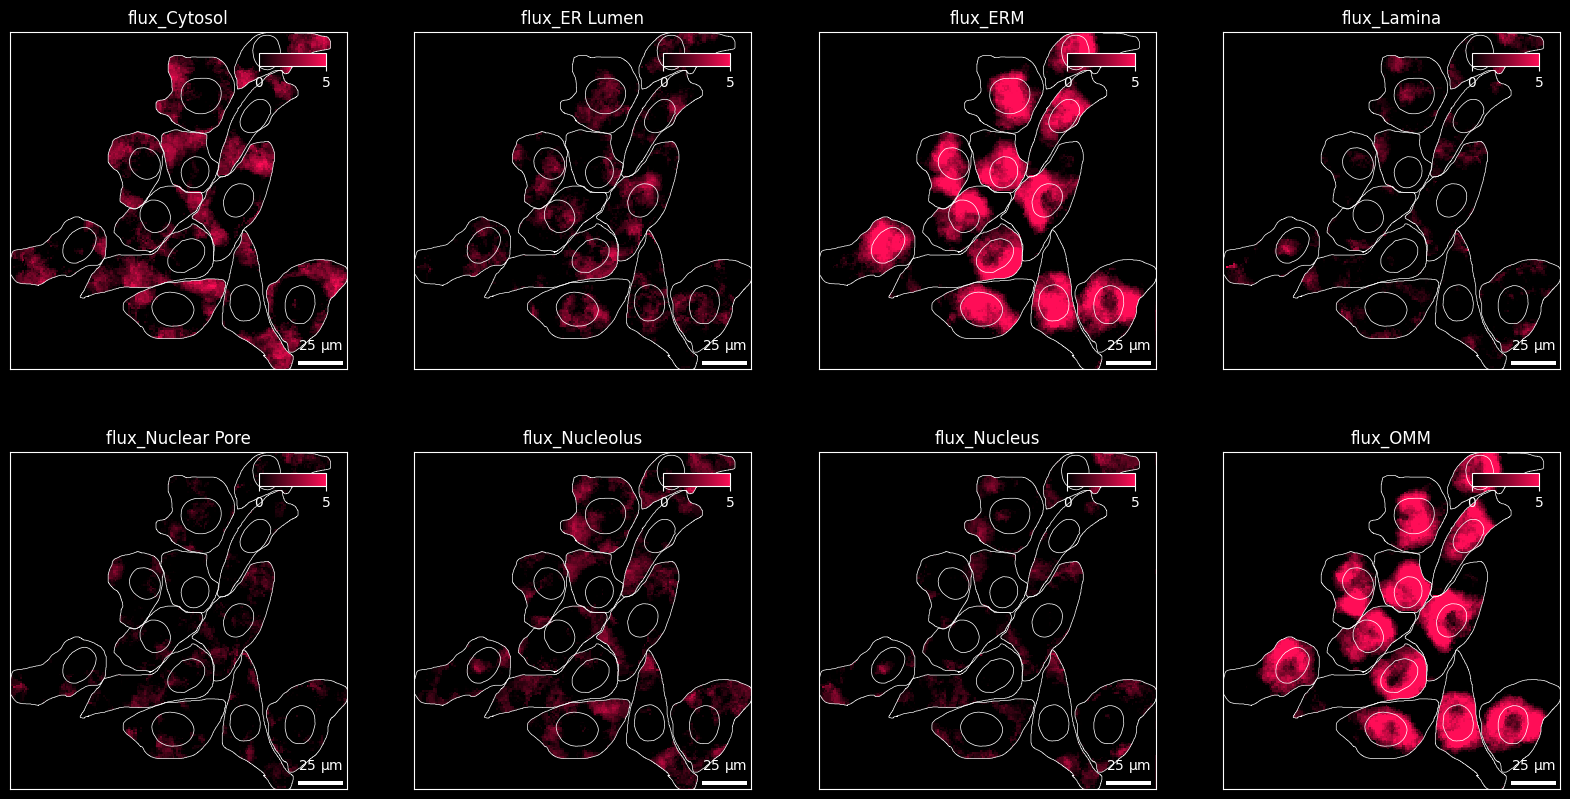

In [23]:
genesets = [
    "flux_Cytosol",
    "flux_ER Lumen",
    "flux_ERM",
    "flux_Lamina",
    "flux_Nuclear Pore",
    "flux_Nucleolus",
    "flux_Nucleus",
    "flux_OMM",
]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for gs, ax in zip(genesets, axes.flat):
    bt.pl.fe(adata, gs, cmap=bt.colors.red_dark, vmin=0, vmax=5, dx=dx, title=gs, ax=ax)


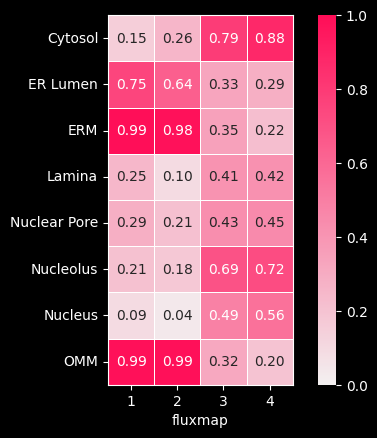

In [24]:
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Cytosol",
        "flux_ER Lumen",
        "flux_ERM",
        "flux_Lamina",
        "flux_Nuclear Pore",
        "flux_Nucleolus",
        "flux_Nucleus",
        "flux_OMM",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    # Count fraction of samples with flux > 1
    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).apply(
        lambda x: (x > 0).sum() / x.shape[0]
    )
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]
    domain_fe = domain_fe.dropna(axis=0)

    domain_fe = domain_fe.iloc[1:, :]

    with mpl.style.context("dark_background"):
        ax = sns.heatmap(
            domain_fe.T,
            vmin=0,
            vmax=1,
            lw=0.5,
            cmap=bt.colors.red_light,
            square=True,
            annot=True,
            fmt=".2f",
        )
        ax.spines[:].set_visible(True)


plot_domain_fe(adata)


In [42]:
adata.obs

: 

: 

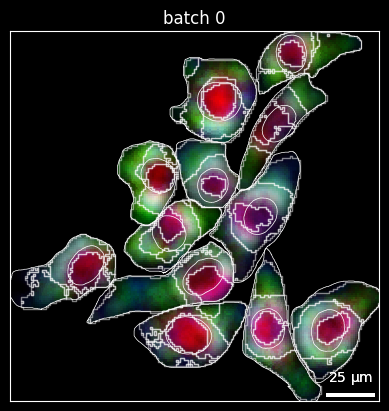

In [41]:
bt.pl.flux(adata, dx=dx)


TODO: Plot specific pairs of fluxmaps and genesets.


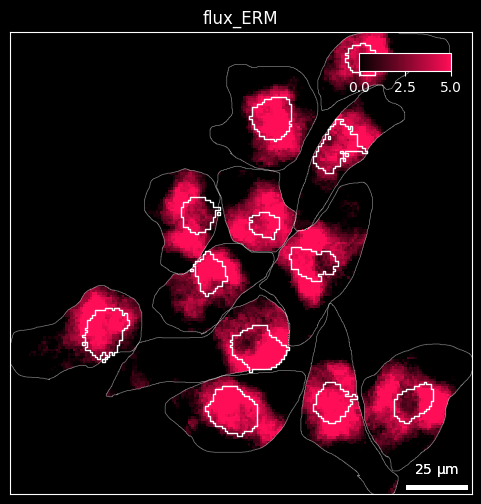

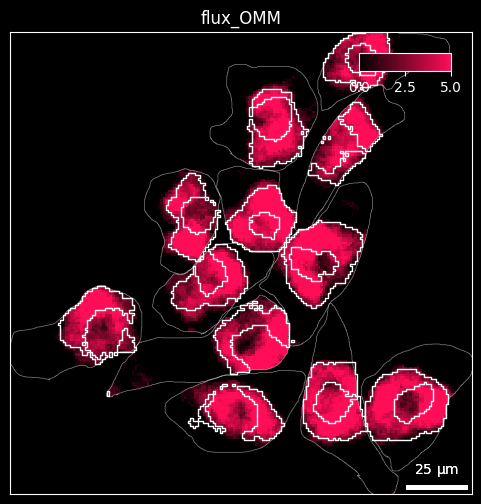

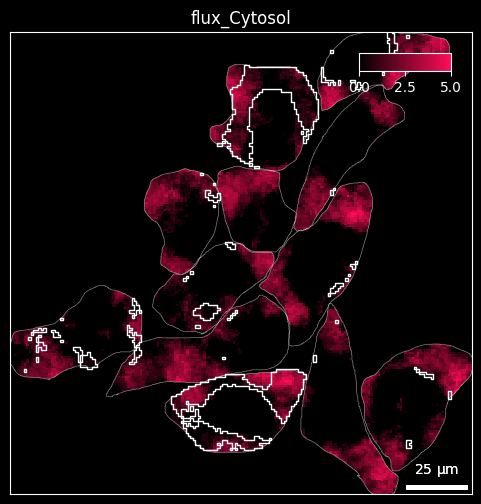

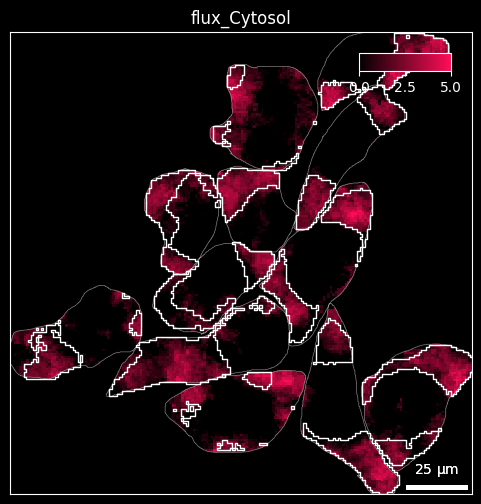

In [37]:
fluxmaps = [f"fluxmap{i}" for i in range(1, 5)]
genesets = ["flux_ERM", "flux_OMM", "flux_Cytosol", "flux_Cytosol"]


for fm, gs in zip(fluxmaps, genesets):
    if gs == "":
        continue
    plt.figure(figsize=(6, 6))
    bt.pl.shapes(adata, shapes=["cell_shape"], alpha=0.5)
    bt.pl.fe(
        adata,
        gs,
        shapes=[fm],
        cmap=bt.colors.red_dark,
        vmin=0,
        vmax=5,
        dx=dx,
        title=gs,
        shape_kws=dict(lw=1),
    )


In [26]:
pc_weights = pd.DataFrame(
    adata.uns["flux_sv"][:25],
    index=[f"PC{i}" for i in range(25)],
    columns=adata.uns["flux_genes"],
)


In [27]:
import decoupler as dc

fazal2019 = bt.tl.load_gene_sets("fazal2019")
fazal2019 = fazal2019.pivot(index="source", columns="target", values="weight").T.fillna(
    0
)
fazal2019.head()


source,Cytosol,ER Lumen,ERM,Lamina,Nuclear Pore,Nucleolus,Nucleus,OMM
target,,,,,,,,
AARS2,-0.280999,0.044633,0.357659,-0.195066,0.291704,-1.225867,0.179871,2.715643
AASDH,-0.290857,-0.470415,-0.616271,0.753356,-0.602657,1.096525,0.418622,-0.845593
AASS,0.016639,-0.131917,1.740126,0.443978,0.529793,0.864569,0.302249,4.236737
ABCA3,-0.011081,0.117976,1.117785,-0.109083,0.119327,-0.427571,-0.308186,1.289387
ABCB10,-0.950674,-0.511049,-0.726714,0.272038,-0.602548,0.247002,-0.144214,1.350953


In [28]:
common_genes = set(fazal2019.index).intersection(set(pc_weights.columns))


In [29]:
all_df = pd.concat([pc_weights[common_genes].T, fazal2019.loc[common_genes]], axis=1)
